In [1]:
# English
import numpy as np
import pandas as pd

In [2]:
train_en = pd.read_csv("NTCIR-13_MedWeb_en_training.csv")
test_en = pd.read_csv("NTCIR-13_MedWeb_en_test.csv")

In [3]:
# remove punctuation inside
import re
def  clean_text_en(df, text_field): 
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [4]:
# update 
train_en = clean_text_en(train_en,"Tweet")
test_en = clean_text_en(test_en,"Tweet")

In [5]:
print('Processing text dataset >>>')
from nltk.tokenize import RegexpTokenizer
from collections import Counter

tokenizer = RegexpTokenizer(r'\w+')
def text_to_wordlist(text, lower=False):
    # Tokenize
    text = tokenizer.tokenize(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in list_sentences:
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

list_train = list(train_en.Tweet)
list_test = list(test_en.Tweet)

tweet_train_en = process_comments(list_train)
tweet_test_en = process_comments(list_test)

Processing text dataset >>>


In [6]:
print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_en, size=100, window=3, min_count=1, sg=1, negative=15)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))


Build word2vec model using Gensim
Number of word vectors: 1814


In [7]:
model.wv.save_word2vec_format('vectorvisual')

In [ ]:
from gensim.models import KeyedVectors

# Load gensim word2vec
w2v_path = 'vectorvisual'
w2v = KeyedVectors.load_word2vec_format(w2v_path)

import io

# Vector file, `\t` seperated the vectors and `\n` seperate the words
"""
0.1\t0.2\t0.5\t0.9
0.2\t0.1\t5.0\t0.2
0.4\t0.1\t7.0\t0.8
"""
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
"""
token1
token2
token3
"""
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.index2word)):
    word = w2v.index2word[index]
    vec = w2v.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_en)

X_train = tokenizer.texts_to_sequences(tweet_train_en)
X_test = tokenizer.texts_to_sequences(tweet_test_en)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index
# word_index.items()

Using TensorFlow backend.


In [9]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [10]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0005)

model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu', strides=1))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='sigmoid'))
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           181500    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           51328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 27, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 13, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 13, 32)            4128      
_________________________________________________________________
flatten_2 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

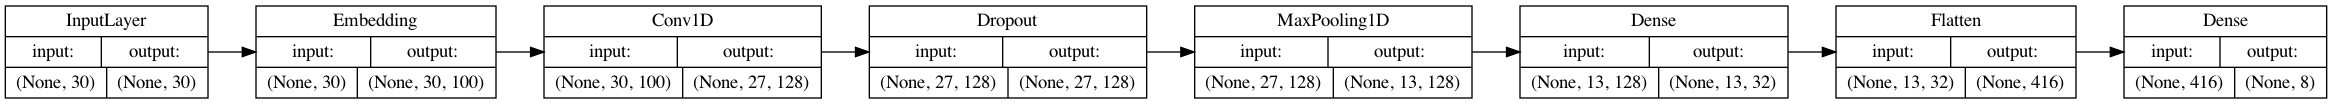

In [12]:

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, rankdir="LR", show_layer_names=False)

In [18]:
list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_en[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_en[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

In [19]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[es])
# class_weight=[{0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7},{0: 0.3, 1: 0.7},{0: 0.3, 1: 0.7},{0: 0.3, 1: 0.7},{0: 0.3, 1: 0.7},{0: 0.3, 1: 0.7}])

Train on 1920 samples, validate on 640 samples
Epoch 1/50
 - 1s - loss: 0.5258 - accuracy: 0.8081 - val_loss: 0.3844 - val_accuracy: 0.8834
Epoch 2/50
 - 1s - loss: 0.3881 - accuracy: 0.8754 - val_loss: 0.3678 - val_accuracy: 0.8834
Epoch 3/50
 - 1s - loss: 0.3701 - accuracy: 0.8754 - val_loss: 0.3547 - val_accuracy: 0.8834
Epoch 4/50
 - 1s - loss: 0.3609 - accuracy: 0.8754 - val_loss: 0.3467 - val_accuracy: 0.8834
Epoch 5/50
 - 1s - loss: 0.3536 - accuracy: 0.8754 - val_loss: 0.3405 - val_accuracy: 0.8834
Epoch 6/50
 - 1s - loss: 0.3448 - accuracy: 0.8754 - val_loss: 0.3338 - val_accuracy: 0.8834
Epoch 7/50
 - 0s - loss: 0.3321 - accuracy: 0.8757 - val_loss: 0.3218 - val_accuracy: 0.8838
Epoch 8/50
 - 0s - loss: 0.3127 - accuracy: 0.8781 - val_loss: 0.3074 - val_accuracy: 0.8865
Epoch 9/50
 - 0s - loss: 0.2864 - accuracy: 0.8891 - val_loss: 0.2897 - val_accuracy: 0.8967
Epoch 10/50
 - 0s - loss: 0.2576 - accuracy: 0.9000 - val_loss: 0.2766 - val_accuracy: 0.8990
Epoch 11/50
 - 0s - lo

In [20]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.9703125
Test precision is 0.5925925925925926
Test recall is 0.6666666666666666
Test f1-score is 0.627450980392157

Diarrhea

Test accuracy is 0.9671875
Test precision is 0.8909090909090909
Test recall is 0.765625
Test f1-score is 0.823529411764706

Hayfever

Test accuracy is 0.959375
Test precision is 0.7272727272727273
Test recall is 0.6956521739130435
Test f1-score is 0.711111111111111

Cough

Test accuracy is 0.93125
Test precision is 0.86
Test recall is 0.5375
Test f1-score is 0.6615384615384615

Headache

Test accuracy is 0.94375
Test precision is 0.8727272727272727
Test recall is 0.6233766233766234
Test f1-score is 0.7272727272727272

Fever

Test accuracy is 0.9234375
Test precision is 0.7444444444444445
Test recall is 0.7204301075268817
Test f1-score is 0.7322404371584699

Runnynose

Test accuracy is 0.9109375
Test precision is 0.8113207547169812
Test recall is 0.6991869918699187
Test f1-score is 0.7510917030567686

Cold

Test accuracy is 0.9296875


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()
    plt.savefig("CNN_Eng.jpg")
plot_history(history)


In [ ]:
# Chinese 

In [21]:
import pandas as pd
import numpy as np

train_zh = pd.read_csv("NTCIR-13_MedWeb_zh_training.csv", na_values='NaN',keep_default_na=False)
test_zh = pd.read_csv("NTCIR-13_MedWeb_zh_test.csv", na_values='NaN',keep_default_na=False)
test_zh = test_zh[:640]

In [22]:
# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_zh(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    return df

# update 
train_zh = clean_text_zh(train_zh,"Tweet")
test_zh = clean_text_zh(test_zh,"Tweet")

tweet_train_zh = list(train_zh.Tweet)
tweet_test_zh = list(test_zh.Tweet)

In [23]:
# introducing tokenizer
import jieba

def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# Tokenization
tweet_train_zh = [list(jieba.cut(i)) for i in tweet_train_zh]
tweet_test_zh = [list(jieba.cut(i)) for i in tweet_test_zh]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/xz/jrlb55l167x3c2jq466bx5fm0000gn/T/jieba.cache
Loading model cost 0.818 seconds.
Prefix dict has been built successfully.


In [24]:
print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_zh, size=100, window=3, min_count=1, workers=3, sg=1)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Build word2vec model using Gensim
Number of word vectors: 2292


In [ ]:
model.wv.save_word2vec_format('vectorvisualzh')

In [ ]:
from gensim.models import KeyedVectors

# Load gensim word2vec
w2v_path = 'vectorvisualzh'
w2v = KeyedVectors.load_word2vec_format(w2v_path)

import io

# Vector file, `\t` seperated the vectors and `\n` seperate the words
"""
0.1\t0.2\t0.5\t0.9
0.2\t0.1\t5.0\t0.2
0.4\t0.1\t7.0\t0.8
"""
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
"""
token1
token2
token3
"""
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.index2word)):
    word = w2v.index2word[index]
    vec = w2v.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [25]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_zh)

X_train = tokenizer.texts_to_sequences(tweet_train_zh)
X_test = tokenizer.texts_to_sequences(tweet_test_zh)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index

In [26]:
word_index.items()

dict_items([('了', 1), ('的', 2), ('是', 3), ('感冒', 4), ('得', 5), ('花粉症', 6), ('头疼', 7), ('很', 8), ('流感', 9), ('就', 10), ('因为', 11), ('也', 12), ('腹泻', 13), ('所以', 14), ('在', 15), ('发烧', 16), ('吧', 17), ('咳嗽', 18), ('好像', 19), ('啊', 20), ('鼻涕', 21), ('今天', 22), ('我', 23), ('开始', 24), ('都', 25), ('有', 26), ('好', 27), ('不', 28), ('吗', 29), ('去', 30), ('说', 31), ('严重', 32), ('会', 33), ('还', 34), ('时候', 35), ('厉害', 36), ('从', 37), ('早上', 38), ('要', 39), ('鼻塞', 40), ('疼', 41), ('又', 42), ('工作', 43), ('虽然', 44), ('没有', 45), ('人', 46), ('请假', 47), ('但', 48), ('药', 49), ('一直', 50), ('可能', 51), ('呢', 52), ('但是', 53), ('难受', 54), ('和', 55), ('上', 56), ('痰', 57), ('休息', 58), ('不能', 59), ('季节', 60), ('伤风', 61), ('着', 62), ('太', 63), ('痛苦', 64), ('能', 65), ('真的', 66), ('拉肚子', 67), ('不行', 68), ('对', 69), ('用', 70), ('被', 71), ('什么', 72), ('的话', 73), ('有点', 74), ('来', 75), ('想', 76), ('里', 77), ('这个', 78), ('最近', 79), ('烧', 80), ('这', 81), ('腮腺炎', 82), ('却', 83), ('吃', 84), ('头', 85), ('不妙', 86), ('一', 8

In [27]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [28]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0005)

model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='sigmoid'))
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           229300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 128)           38528     
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 14, 32)            4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                

In [30]:
list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_zh[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_zh[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

In [31]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=64,
                    validation_data=(X_test, y_test), callbacks=[es])

Train on 1919 samples, validate on 640 samples
Epoch 1/50
 - 1s - loss: 0.5694 - accuracy: 0.7699 - val_loss: 0.4011 - val_accuracy: 0.8834
Epoch 2/50
 - 0s - loss: 0.3849 - accuracy: 0.8754 - val_loss: 0.3692 - val_accuracy: 0.8834
Epoch 3/50
 - 0s - loss: 0.3709 - accuracy: 0.8754 - val_loss: 0.3548 - val_accuracy: 0.8834
Epoch 4/50
 - 1s - loss: 0.3644 - accuracy: 0.8754 - val_loss: 0.3490 - val_accuracy: 0.8834
Epoch 5/50
 - 0s - loss: 0.3592 - accuracy: 0.8754 - val_loss: 0.3464 - val_accuracy: 0.8834
Epoch 6/50
 - 1s - loss: 0.3530 - accuracy: 0.8754 - val_loss: 0.3430 - val_accuracy: 0.8834
Epoch 7/50
 - 0s - loss: 0.3442 - accuracy: 0.8754 - val_loss: 0.3332 - val_accuracy: 0.8834
Epoch 8/50
 - 1s - loss: 0.3300 - accuracy: 0.8758 - val_loss: 0.3227 - val_accuracy: 0.8842
Epoch 9/50
 - 1s - loss: 0.3063 - accuracy: 0.8794 - val_loss: 0.3015 - val_accuracy: 0.8865
Epoch 10/50
 - 0s - loss: 0.2693 - accuracy: 0.8913 - val_loss: 0.2693 - val_accuracy: 0.8936
Epoch 11/50
 - 1s - lo

In [32]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.9640625
Test precision is 0.52
Test recall is 0.5416666666666666
Test f1-score is 0.5306122448979592

Diarrhea

Test accuracy is 0.940625
Test precision is 0.7321428571428571
Test recall is 0.640625
Test f1-score is 0.6833333333333332

Hayfever

Test accuracy is 0.975
Test precision is 0.9166666666666666
Test recall is 0.717391304347826
Test f1-score is 0.8048780487804877

Cough

Test accuracy is 0.9296875
Test precision is 0.8888888888888888
Test recall is 0.5
Test f1-score is 0.64

Headache

Test accuracy is 0.9671875
Test precision is 0.868421052631579
Test recall is 0.8571428571428571
Test f1-score is 0.8627450980392157

Fever

Test accuracy is 0.9125
Test precision is 0.7176470588235294
Test recall is 0.6559139784946236
Test f1-score is 0.6853932584269663

Runnynose

Test accuracy is 0.9125
Test precision is 0.819047619047619
Test recall is 0.6991869918699187
Test f1-score is 0.7543859649122807

Cold

Test accuracy is 0.9265625
Test precision is 0.864

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()

    plt.savefig("CNN_Chi.jpg")
plot_history(history)


In [ ]:
# Japanese

In [33]:
import pandas as pd
import numpy as np

train_ja = pd.read_csv("NTCIR-13_MedWeb_ja_training.csv", na_values='NaN',keep_default_na=False)
test_ja = pd.read_csv("NTCIR-13_MedWeb_ja_test.csv", na_values='NaN',keep_default_na=False)
test_ja = test_ja[:640]

In [34]:
# remove punctuation inside
import re
from zhon.hanzi import punctuation

def clean_text_ja(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem:re.sub(r'[{}]+'.format(punctuation),'',elem))
    return df

# update 
train_ja = clean_text_ja(train_ja,"Tweet")
test_ja = clean_text_ja(test_ja,"Tweet")

In [35]:
# setup Japanese tokenizer
import nagisa

def tokenize_jp(doc):
    doc = nagisa.tagging(doc)
    return doc.words

tweet_train_ja = [list(tokenize_jp(i)) for i in train_ja.Tweet]
tweet_test_ja = [list(tokenize_jp(i)) for i in test_ja.Tweet]

In [36]:
print('Build word2vec model using Gensim')

from gensim.models import Word2Vec
model = Word2Vec(tweet_train_ja, size=100, window=5, min_count=1, workers=3, sg=1, negative=15)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

# print(model['全身'])

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 2161 word types from a corpus of 23974 raw words and 1920 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 2161 unique words (100% of original 2161, drops 0)
effective_min_count=1 leaves 23974 word corpus (100% of original 23974, drops 0)
deleting the raw counts dictionary of 2161 items
sample=0.001 downsamples 51 most-common words
downsampling leaves estimated 14748 word corpus (61.5% of prior 23974)
estimated required memory for 2161 words and 100 dimensions: 2809300 bytes
resetting layer weights


Build word2vec model using Gensim


training model with 3 workers on 2161 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=15 window=5
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 23974 raw words (14696 effective words) took 0.1s, 100713 effective words/s
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 23974 raw words (14828 effective words) took 0.1s, 134034 effective words/s
worker thread finished; awaiting finish of 2 more threads
worker thread finished; awaiting finish of 1 more threads
worker thread finished; awaiting finish of 0 more threads
EPOCH - 3 : training on 23974 raw words (14699 effective words) took 0.1s, 137377 effective words/s
worker thread finished; awaiting finish of 2 more threads
wor

Number of word vectors: 2161


In [ ]:
model.wv.save_word2vec_format('vectorvisualjp')

In [ ]:
from gensim.models import KeyedVectors

# Load gensim word2vec
w2v_path = 'vectorvisualjp'
w2v = KeyedVectors.load_word2vec_format(w2v_path)

import io

# Vector file, `\t` seperated the vectors and `\n` seperate the words
"""
0.1\t0.2\t0.5\t0.9
0.2\t0.1\t5.0\t0.2
0.4\t0.1\t7.0\t0.8
"""
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
"""
token1
token2
token3
"""
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.index2word)):
    word = w2v.index2word[index]
    vec = w2v.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [37]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_train_ja)

X_train = tokenizer.texts_to_sequences(tweet_train_ja)
X_test = tokenizer.texts_to_sequences(tweet_test_ja)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

word_index = tokenizer.word_index

In [38]:
word_index.items()

dict_items([('が', 1), ('て', 2), ('の', 3), ('た', 4), ('に', 5), ('で', 6), ('だ', 7), ('し', 8), ('は', 9), ('と', 10), ('を', 11), ('か', 12), ('も', 13), ('風邪', 14), ('ない', 15), ('から', 16), ('頭痛', 17), ('花粉', 18), ('症', 19), ('な', 20), ('熱', 21), ('下痢', 22), ('・', 23), ('けど', 24), ('よ', 25), ('ん', 26), ('って', 27), ('する', 28), ('咳', 29), ('鼻水', 30), ('なっ', 31), ('てる', 32), ('インフル', 33), ('たら', 34), ('やばい', 35), ('インフルエンザ', 36), ('今日', 37), ('き', 38), ('ある', 39), ('らしい', 40), ('出', 41), ('薬', 42), ('ね', 43), ('鼻づまり', 44), ('いる', 45), ('朝', 46), ('仕事', 47), ('痛い', 48), ('対策', 49), ('止まら', 50), ('わ', 51), ('ひどい', 52), ('すぎ', 53), ('お腹', 54), ('痰', 55), ('こと', 56), ('なる', 57), ('休む', 58), ('い', 59), ('まさか', 60), ('季節', 61), ('れ', 62), ('思っ', 63), ('人', 64), ('頭', 65), ('最悪', 66), ('ひい', 67), ('だるい', 68), ('っぽい', 69), ('なく', 70), ('なん', 71), ('だっ', 72), ('とき', 73), ('まだ', 74), ('さ', 75), ('久し', 76), ('感染', 77), ('鼻', 78), ('この', 79), ('かかっ', 80), ('最近', 81), ('鳥', 82), ('出る', 83), ('ワクチン', 84), ('お'

In [39]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [40]:
EMBEDDING_DIM=100
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))

for word, i in word_index.items():
    if i > vocab_size:
        continue
    embedding_vector = word_vectors[word]
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0005)

model = Sequential()
embedding_layer = Embedding(vocab_size,
                     EMBEDDING_DIM,
                     mask_zero=False,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=maxlen,
                     trainable=True)
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='sigmoid'))
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           216200    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 128)           38528     
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 14, 32)            4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [42]:
list_classes = ["Influenza", "Diarrhea","Hayfever","Cough","Headache","Fever","Runnynose","Cold"]
result_train = train_ja[list_classes].replace({'n':0, 'p':+1})
y_train = result_train[list_classes].values

result_test = test_ja[list_classes].replace({'n':0, 'p':+1})
y_test = result_test[list_classes].values

In [43]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
) # add early stopping

history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=2,
                    batch_size=64,
                    validation_data=(X_test, y_test),callbacks=[es])

Train on 1920 samples, validate on 640 samples
Epoch 1/50
 - 1s - loss: 0.5086 - accuracy: 0.8438 - val_loss: 0.3716 - val_accuracy: 0.8834
Epoch 2/50
 - 0s - loss: 0.3778 - accuracy: 0.8754 - val_loss: 0.3558 - val_accuracy: 0.8834
Epoch 3/50
 - 0s - loss: 0.3651 - accuracy: 0.8754 - val_loss: 0.3528 - val_accuracy: 0.8834
Epoch 4/50
 - 1s - loss: 0.3601 - accuracy: 0.8754 - val_loss: 0.3488 - val_accuracy: 0.8834
Epoch 5/50
 - 0s - loss: 0.3543 - accuracy: 0.8754 - val_loss: 0.3443 - val_accuracy: 0.8834
Epoch 6/50
 - 1s - loss: 0.3432 - accuracy: 0.8754 - val_loss: 0.3321 - val_accuracy: 0.8834
Epoch 7/50
 - 1s - loss: 0.3230 - accuracy: 0.8774 - val_loss: 0.3093 - val_accuracy: 0.8869
Epoch 8/50
 - 0s - loss: 0.2942 - accuracy: 0.8841 - val_loss: 0.2854 - val_accuracy: 0.8953
Epoch 9/50
 - 1s - loss: 0.2626 - accuracy: 0.8902 - val_loss: 0.2598 - val_accuracy: 0.8984
Epoch 10/50
 - 1s - loss: 0.2342 - accuracy: 0.9005 - val_loss: 0.2434 - val_accuracy: 0.9049
Epoch 11/50
 - 0s - lo

In [44]:
# calculate metrics
pred_test = model.predict(X_test)
classes = pred_test > 0.5
pred_test = classes.astype(int) # update predicted value

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# initialize
ac = 0 
pre = 0
rec = 0
f1_s = 0

for i in range (0,8):
    
    prediction = pred_test[:, i]
    y_sys = y_test[:,i]
    print(list_classes[i])
    print('\nTest accuracy is {}'.format(accuracy_score(y_sys, prediction)))
    print('Test precision is {}'.format(precision_score(y_sys, prediction, average='binary')))
    print('Test recall is {}'.format(recall_score(y_sys, prediction, average='binary')))
    print('Test f1-score is {}\n'.format(f1_score(y_sys, prediction, average='binary')))
    
    temp_accuracy = accuracy_score(y_sys, prediction)
    ac = ac + temp_accuracy
    
    temp_precision = precision_score(y_sys, prediction, average='binary')
    pre = pre + temp_precision
    
    temp_recall = recall_score(y_sys, prediction, average='binary')
    rec = rec + temp_recall
    
    temp_f1_score = f1_score(y_sys, prediction, average='binary')
    f1_s= f1_s + temp_f1_score

print("Summary\n>>>>>>>>>>>>>>>>>>>>>\n")
ava_accuracy = ac/8
print('The average accuracy is {}'.format(ava_accuracy))

ava_precision = pre/8
print('The average precision is {}'.format(ava_precision))

ava_recall = rec/8
print('The average recall is {}'.format(ava_recall))

ava_f1_score = f1_s/8
print('The average f1 score is {}'.format(ava_f1_score))

Influenza

Test accuracy is 0.9765625
Test precision is 0.7647058823529411
Test recall is 0.5416666666666666
Test f1-score is 0.6341463414634146

Diarrhea

Test accuracy is 0.9625
Test precision is 0.8703703703703703
Test recall is 0.734375
Test f1-score is 0.7966101694915254

Hayfever

Test accuracy is 0.975
Test precision is 0.8125
Test recall is 0.8478260869565217
Test f1-score is 0.8297872340425533

Cough

Test accuracy is 0.9671875
Test precision is 0.927536231884058
Test recall is 0.8
Test f1-score is 0.8590604026845639

Headache

Test accuracy is 0.9703125
Test precision is 0.9264705882352942
Test recall is 0.8181818181818182
Test f1-score is 0.8689655172413794

Fever

Test accuracy is 0.91875
Test precision is 0.7733333333333333
Test recall is 0.6236559139784946
Test f1-score is 0.6904761904761905

Runnynose

Test accuracy is 0.9390625
Test precision is 0.8888888888888888
Test recall is 0.7804878048780488
Test f1-score is 0.8311688311688312

Cold

Test accuracy is 0.9234375
Tes

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Test accuracy')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and testing loss')
    plt.legend()
    plt.savefig("CNN_jap.jpg")
    
plot_history(history)
